# Using PyTorch to recognize hand-written digits with Watson Machine Learning REST API

#### Notebook created by Jan Soltysik and updated by Kelvin Lui, November 2020

This notebook contains steps and code to demonstrate support of PyTorch Deep Learning experiments in the Watson Machine Learning service on Cloud Pak for Data 3.5. It introduces commands for getting data, training experiments, persisting pipelines, publishing models, deploying models and scoring.

Some familiarity with cURL is helpful. This notebook uses cURL examples.


## Learning goals

The learning goals of this notebook are:

Working with Watson Machine Learning experiments to offload and accelerate deep learning model training with Watson Machine Learning Accelerator. 
Downloading computed models from Watson Machine Learning Accelerator to Watson Machine Learning.
Online deployment and scoring of a trained model using Watson Machine Learning. 

## Contents

This notebook contains the following parts:

1.	[Set up the environment](#setup)   
2.  [Model definition](#model_definition)  
3.	[Experiment Run](#run)  
4.	[Historical runs](#runs)  
5.	[Deploy and Score](#deploy_and_score)  
6.	[Cleaning](#cleaning)   
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask them for your account credentials

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide the following: the platform `url`, your `username` and `password`.

In [4]:
%env USERNAME=wendy
%env PASSWORD=Passw0rd2021
%env DATAPLATFORM_URL=https://daell-wmla.datascienceelite.com

%env SPACE_ID=

env: USERNAME=wendy
env: PASSWORD=Passw0rd2021
env: DATAPLATFORM_URL=https://daell-wmla.datascienceelite.com
env: SPACE_ID=


<a id="wml_token"></a>
### Getting WML authorization token for further cURL calls

<a href="https://cloud.ibm.com/docs/cloud-object-storage?topic=cloud-object-storage-curl#curl-token" target="_blank" rel="noopener no referrer">Example of cURL call to get WML token</a>

In [5]:
%%bash --out token

curl -sk -X GET \
    --user $USERNAME:$PASSWORD \
    --header "Accept: application/json" \
    "$DATAPLATFORM_URL/v1/preauth/validateAuth" \
    | cut -d '"' -f 44

In [6]:
%env TOKEN=$token 

env: TOKEN=sub


<a id="space_creation"></a>
### Space creation
**Tip:** If you do not have `space` already created, convert the three cells below to `code` and run them.

First, create a `space` that will be used for all of your cURL calls. 
If you do not have a `space` already created, use the cURL call below to create one.

<a href="https://cpd-spaces-api.eu-gb.cf.appdomain.cloud/#/Spaces/spaces_create" 
target="_blank" rel="noopener no referrer">Space creation</a>

In [6]:
%%bash --out space_id

curl -sk -X POST \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data '{"name": "curl_DL_1"}' \
    "$DATAPLATFORM_URL/v2/spaces" \
     | grep '"id": ' | awk -F '"' '{ print $4 }'

In [7]:
space_id = space_id.split('\n')[1]
%env SPACE_ID=$space_id

env: SPACE_ID=3bc745cb-ba43-49ed-992c-b3454f4f3e6d


Space creation is asynchronous. This means that you need to check space creation status after creation call.
Make sure that your newly created space is `active`.

<a href="https://cpd-spaces-api.eu-gb.cf.appdomain.cloud/#/Spaces/spaces_get" 
target="_blank" rel="noopener no referrer">Get space information</a>

In [8]:
%%bash

curl -sk -X GET \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    "$DATAPLATFORM_URL/v2/spaces/$SPACE_ID"

{
  "entity": {
    "compute": [{
      "crn": "crn:v1:cpd:private:pm-20:private:a/cpduser:99999999-9999-9999-9999-999999999999::",
      "guid": "99999999-9999-9999-9999-999999999999",
      "name": "Watson Machine Learning",
      "type": "machine_learning"
    }],
    "name": "curl_DL_1",
    "scope": {
      "bss_account_id": "cpdaccount"
    },
    "status": {
      "state": "preparing"
    }
  },
  "metadata": {
    "created_at": "2020-11-19T17:46:54.832Z",
    "creator_id": "1000330999",
    "id": "3bc745cb-ba43-49ed-992c-b3454f4f3e6d",
    "updated_at": "2020-11-19T17:46:56.043Z",
    "url": "/v2/spaces/3bc745cb-ba43-49ed-992c-b3454f4f3e6d"
  }
}

<a id="model_definition"></a>
## 2. Model definition 

This section provides samples about how to store model definition via cURL calls.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Model%20Definitions/model_definitions_create" 
target="_blank" rel="noopener no referrer">Store a model definition for Deep Learning experiment</a>

In [9]:
%%bash --out model_definition_payload

MODEL_DEFINITION_PAYLOAD='{"name": "PyTorch Hand-written Digit Recognition", "space_id": "'"$SPACE_ID"'", "description": "PyTorch Hand-written Digit Recognition", "tags": ["DL", "PyTorch"], "version": "v1", "platform": {"name": "python", "versions": ["3.7"]}, "command": "pytorch_v_1.1_mnist_onnx.py --epochs 10 --debug-level debug"}'
echo $MODEL_DEFINITION_PAYLOAD | python -m json.tool

In [10]:
%env MODEL_DEFINITION_PAYLOAD=$model_definition_payload

env: MODEL_DEFINITION_PAYLOAD={
    "name": "PyTorch Hand-written Digit Recognition",
    "space_id": "3bc745cb-ba43-49ed-992c-b3454f4f3e6d",
    "description": "PyTorch Hand-written Digit Recognition",
    "tags": [
        "DL",
        "PyTorch"
    ],
    "version": "v1",
    "platform": {
        "name": "python",
        "versions": [
            "3.7"
        ]
    },
    "command": "pytorch_v_1.1_mnist_onnx.py --epochs 10 --debug-level debug"
}


In [11]:
%%bash --out model_definition_id

curl -sk -X POST \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data "$MODEL_DEFINITION_PAYLOAD" \
    "$DATAPLATFORM_URL/ml/v4/model_definitions?version=2020-08-01"| grep '"id": ' | awk -F '"' '{ print $4 }'

In [12]:
%env MODEL_DEFINITION_ID=$model_definition_id

env: MODEL_DEFINITION_ID=ea1d5f5e-5749-44f6-9f55-33f3b9285676


<a id="model_preparation"></a>
### Model preparation

Download files with PyTorch code. You can either download the model PyTorch code using the link or run the cell below.

<a href="https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd/definitions/pytorch/mnist/pytorch-onnx_v1_3.zip" 
target="_blank" rel="noopener no referrer">Download pytorch-model.zip</a>

In [13]:
%%bash

wget https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd/definitions/pytorch/mnist/pytorch_onnx_v1_3.zip \
     -O pytorch-onnx_v1_3.zip

--2020-11-19 17:47:29--  https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd/definitions/pytorch/mnist/pytorch_onnx_v1_3.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cpd/definitions/pytorch/mnist/pytorch_onnx_v1_3.zip [following]
--2020-11-19 17:47:29--  https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cpd/definitions/pytorch/mnist/pytorch_onnx_v1_3.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4061 (4.0K) [application/zip]
Saving to: ‘pytorch-onnx_v1_3.zip’

     0K ...                           

<a id="def_upload"></a>
### Upload model for the model definition

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Model%20Definitions/model_definitions_upload_model" 
target="_blank" rel="noopener no referrer">Upload model for the model definition</a>

In [14]:
%%bash

curl -sk -X PUT \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data-binary "@pytorch-onnx_v1_3.zip" \
    "$DATAPLATFORM_URL/ml/v4/model_definitions/$MODEL_DEFINITION_ID/model?version=2020-08-01&space_id=$SPACE_ID" \
    | python -m json.tool

{
    "attachment_id": "e33c7a60-c8bc-4790-b033-ace3dd2319bc",
    "content_format": "native",
    "persisted": true
}


<a id="run"></a>
## 3. Experiment run

This section provides samples about how to trigger Deep Learning experiment via cURL calls.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Trainings/trainings_create" 
target="_blank" rel="noopener no referrer">Schedule a training job for Deep Learning experiment</a>

Specify the source files folder where you have stored your training data. The path should point to a local repository on Watson Machine Learning Accelerator that your system administrator has set up for your use.

**Action:**
Change `training_data_references: location: path: ...`

In [15]:
%%bash --out training_payload

TRAINING_PAYLOAD='{"training_data_references": [{"name": "training_input_data", "type": "fs", "connection": {}, "location": {"path": "pytorch-mnist"}, "schema": {"id": "idmlp_schema", "fields": [{"name": "text", "type": "string"}]}}], "results_reference": {"name": "MNIST results", "connection": {}, "location": {"path": "spaces/'"$SPACE_ID"'/assets/experiment"}, "type": "fs"}, "tags": [{"value": "tags_pytorch", "description": "Tags PyTorch"}], "name": "PyTorch hand-written Digit Recognition", "description": "PyTorch hand-written Digit Recognition", "model_definition": {"id": "'"$MODEL_DEFINITION_ID"'", "command": "pytorch_v_1.1_mnist_onnx.py --epochs 10 --debug-level debug", "hardware_spec": {"name": "K80", "nodes": 1}, "software_spec": {"name": "pytorch-onnx_1.3-py3.7"}, "parameters": {"name": "PyTorch_mnist", "description": "PyTorch mnist recognition"}}, "space_id": "'"$SPACE_ID"'"}'
echo $TRAINING_PAYLOAD | python -m json.tool

In [16]:
%env TRAINING_PAYLOAD=$training_payload

env: TRAINING_PAYLOAD={
    "training_data_references": [
        {
            "name": "training_input_data",
            "type": "fs",
            "connection": {},
            "location": {
                "path": "pytorch-mnist"
            },
            "schema": {
                "id": "idmlp_schema",
                "fields": [
                    {
                        "name": "text",
                        "type": "string"
                    }
                ]
            }
        }
    ],
    "results_reference": {
        "name": "MNIST results",
        "connection": {},
        "location": {
            "path": "spaces/3bc745cb-ba43-49ed-992c-b3454f4f3e6d/assets/experiment"
        },
        "type": "fs"
    },
    "tags": [
        {
            "value": "tags_pytorch",
            "description": "Tags PyTorch"
        }
    ],
    "name": "PyTorch hand-written Digit Recognition",
    "description": "PyTorch hand-written Digit Recognition",
    "model_definition"

In [17]:
%%bash --out training_id

curl -sk -X  POST \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data "$TRAINING_PAYLOAD" \
    "$DATAPLATFORM_URL/ml/v4/trainings?version=2020-08-01" | awk -F'"id":' '{print $2}' | cut -c2-37

In [18]:
%env TRAINING_ID=$training_id

env: TRAINING_ID=c840051a-4e06-48dc-a767-2302058ed70f


<a id="training_details"></a>
### Get training details
Training is an asynchronous endpoint. In case you want to monitor training status and details,
you need to use a GET method and specify which training you want to monitor by usage of training ID.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Trainings/trainings_get" 
target="_blank" rel="noopener no referrer">Get information about training job</a>

### Get training status

In [21]:
%%bash

STATUS=$(curl -sk -X GET\
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    "$DATAPLATFORM_URL/ml/v4/trainings/$TRAINING_ID?space_id=$SPACE_ID&version=2020-08-01")
    
STATUS=${STATUS#*state\":\"}
STATUS=${STATUS%%\"*}
echo $STATUS

completed


Please make sure that training is completed before you go to the next sections.
Monitor `state` of your training by running above cell couple of times.

<a id="runs"></a>
## 4. Historical runs

In this section you will see cURL examples describing how to get historical training run information.

Output is similar to the output from training creation but you should see more trainings entries.  
List training runs:

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Trainings/trainings_list" 
target="_blank" rel="noopener no referrer">Get list of historical training jobs information</a>

In [22]:
%%bash

HISTORICAL_TRAINING_LIMIT_TO_GET=2

curl -sk -X GET \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    "$DATAPLATFORM_URL/ml/v4/trainings?space_id=$SPACE_ID&version=2020-08-01&limit=$HISTORICAL_TRAINING_LIMIT_TO_GET" \
    | python -m json.tool

{
    "limit": 2,
    "resources": [
        {
            "metadata": {
                "created_at": "2020-11-19T17:47:49.812Z",
                "description": "PyTorch hand-written Digit Recognition",
                "guid": "c840051a-4e06-48dc-a767-2302058ed70f",
                "id": "c840051a-4e06-48dc-a767-2302058ed70f",
                "modified_at": "2020-11-19T17:50:55.499Z",
                "name": "PyTorch hand-written Digit Recognition",
                "space_id": "3bc745cb-ba43-49ed-992c-b3454f4f3e6d",
                "tags": [
                    "tags_pytorch"
                ]
            },
            "entity": {
                "description": "PyTorch hand-written Digit Recognition",
                "model_definition": {
                    "command": "pytorch_v_1.1_mnist_onnx.py --epochs 10 --debug-level debug",
                    "hardware_spec": {
                        "name": "K80"
                    },
                    "id": "ea1d5f5e-5749-44f6-9f55-33f

<a id="training_cancel"></a>
### Cancel training run

**Tip:** If you want to cancel your training, convert the cell below to `code`, specify training ID and run.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Trainings/trainings_delete" 
target="_blank" rel="noopener no referrer">Canceling training</a>

---

<a id="deploy_and_score"></a>
## 5. Deploy and core

In this section you will learn how to deploy and score a pipeline model as a web service using a WML instance.

Before deployment creation, you need store your model in WML repository.
Please see below cURL call example how to do it.

Download `request.json` with repository request json for model storing.

In [23]:
%%bash --out request_json

curl -sk -X GET \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    "$DATAPLATFORM_URL/v2/asset_files/experiment/$TRAINING_ID/assets/$TRAINING_ID/resources/wml_model/request.json?space_id=$SPACE_ID&version=2020-08-01" \
    | python -m json.tool

In [24]:
%env MODEL_PAYLOAD=$request_json

env: MODEL_PAYLOAD={
    "content_location": {
        "connection": {},
        "contents": [
            {
                "content_format": "native",
                "file_name": "twmla-1314.zip",
                "location": "spaces/3bc745cb-ba43-49ed-992c-b3454f4f3e6d/assets/experiment/c840051a-4e06-48dc-a767-2302058ed70f/assets/c840051a-4e06-48dc-a767-2302058ed70f/resources/wml_model/twmla-1314.zip"
            }
        ],
        "location": {
            "path": "spaces/3bc745cb-ba43-49ed-992c-b3454f4f3e6d/assets/experiment",
            "model": "spaces/3bc745cb-ba43-49ed-992c-b3454f4f3e6d/assets/experiment/c840051a-4e06-48dc-a767-2302058ed70f/data/model",
            "training": "spaces/3bc745cb-ba43-49ed-992c-b3454f4f3e6d/assets/experiment/c840051a-4e06-48dc-a767-2302058ed70f",
            "training_status": "spaces/3bc745cb-ba43-49ed-992c-b3454f4f3e6d/assets/experiment/c840051a-4e06-48dc-a767-2302058ed70f/training-status.json",
            "logs": "spaces/3bc745cb-ba43-49ed

<a id="model_store"></a>
### Store deep learning model

Store information about your model in the WML repository.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Models/models_create" 
target="_blank" rel="noopener no referrer">Model storing</a>

In [25]:
%%bash --out model_details

curl -sk -X POST \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data "$MODEL_PAYLOAD" \
    "$DATAPLATFORM_URL/ml/v4/models?version=2020-08-01&space_id=$SPACE_ID"

In [26]:
%env MODEL_DETAILS=$model_details

env: MODEL_DETAILS={
  "entity": {
    "content_import_state": "running",
    "model_definition": {
      "id": "ea1d5f5e-5749-44f6-9f55-33f3b9285676"
    },
    "software_spec": {
      "id": "8d5d8a87-a912-54cf-81ec-3914adaa988d",
      "name": "pytorch-onnx_1.3-py3.7"
    },
    "training_data_references": [{
      "connection": {

      },
      "location": {
        "path": "pytorch-mnist"
      },
      "schema": {
        "fields": [{
          "name": "text",
          "type": "string"
        }],
        "id": "idmlp_schema"
      },
      "type": "fs"
    }],
    "type": "pytorch-onnx_1.3"
  },
  "metadata": {
    "created_at": "2020-11-19T17:52:19.456Z",
    "id": "20dde42f-6aec-41eb-b147-5ffdd60dada3",
    "modified_at": "2020-11-19T17:52:19.456Z",
    "name": "model_twmla-1314",
    "owner": "1000330999",
    "space_id": "3bc745cb-ba43-49ed-992c-b3454f4f3e6d"
  },
  "system": {
    "warnings": []
  }
}


In [27]:
%%bash --out model_id

echo $MODEL_DETAILS | awk -F '"id": ' '{ print $5 }' | cut -d '"' -f 2

In [28]:
%env MODEL_ID=$model_id

env: MODEL_ID=20dde42f-6aec-41eb-b147-5ffdd60dada3


<a id="deployment_creation"></a>
### Deployment creation

An Deep Learning online deployment creation is presented below.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Deployments/deployments_create" 
target="_blank" rel="noopener no referrer">Create deployment</a>

In [29]:
%%bash --out deployment_payload

DEPLOYMENT_PAYLOAD='{"space_id": "'"$SPACE_ID"'","name": "PyTorch Mnist deployment", "description": "PyTorch model to recognize hand-written digits","online": {},"hardware_spec": {"name": "S"},"asset": {"id": "'"$MODEL_ID"'"}}'
echo $DEPLOYMENT_PAYLOAD | python -m json.tool

In [30]:
%env DEPLOYMENT_PAYLOAD=$deployment_payload

env: DEPLOYMENT_PAYLOAD={
    "space_id": "3bc745cb-ba43-49ed-992c-b3454f4f3e6d",
    "name": "PyTorch Mnist deployment",
    "description": "PyTorch model to recognize hand-written digits",
    "online": {},
    "hardware_spec": {
        "name": "S"
    },
    "asset": {
        "id": "20dde42f-6aec-41eb-b147-5ffdd60dada3"
    }
}


In [31]:
%%bash

curl -sk -X POST \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data "$DEPLOYMENT_PAYLOAD" \
    "$DATAPLATFORM_URL/ml/v4/deployments?version=2020-08-01"

{
  "entity": {
    "asset": {
      "id": "20dde42f-6aec-41eb-b147-5ffdd60dada3"
    },
    "custom": {

    },
    "deployed_asset_type": "model",
    "description": "PyTorch model to recognize hand-written digits",
    "hardware_spec": {
      "id": "e7ed1d6c-2e89-42d7-aed5-863b972c1d2b",
      "name": "S",
      "num_nodes": 1
    },
    "name": "PyTorch Mnist deployment",
    "online": {

    },
    "space_id": "3bc745cb-ba43-49ed-992c-b3454f4f3e6d",
    "status": {
      "online_url": {
        "url": "https://wmlgm-cpd-wmlgm.apps.wml1x180.ma.platformlab.ibm.com/ml/v4/deployments/17d2908b-7632-4d26-8c25-d8ac0d44754c/predictions"
      },
      "state": "initializing"
    }
  },
  "metadata": {
    "created_at": "2020-11-19T17:52:44.729Z",
    "description": "PyTorch model to recognize hand-written digits",
    "id": "17d2908b-7632-4d26-8c25-d8ac0d44754c",
    "modified_at": "2020-11-19T17:52:44.729Z",
    "name": "PyTorch Mnist deployment",
    "owner": "1000330999",
    "space_i

In [32]:
%%bash --out deployment_id

curl -sk -X POST \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data "$DEPLOYMENT_PAYLOAD" \
    "$DATAPLATFORM_URL/ml/v4/deployments?version=2020-08-01" \
    | grep '"id": ' | awk -F '"' '{ print $4 }' | sed -n 3p

In [33]:
%env DEPLOYMENT_ID=$deployment_id

env: DEPLOYMENT_ID=0c74dc16-8b3a-45d6-b0fa-ccb4025d02e7


<a id="deployment_details"></a>
### Get deployment details
As deployment API is asynchronous, make sure that your deployment is in `ready` state before going to the next section.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Deployments/deployments_get" 
target="_blank" rel="noopener no referrer">Get deployment details</a>

In [34]:
%%bash

curl -sk -X GET \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    "$DATAPLATFORM_URL/ml/v4/deployments/$DEPLOYMENT_ID?space_id=$SPACE_ID&version=2020-08-01" \
    | python -m json.tool

{
    "entity": {
        "asset": {
            "id": "20dde42f-6aec-41eb-b147-5ffdd60dada3"
        },
        "custom": {},
        "deployed_asset_type": "model",
        "description": "PyTorch model to recognize hand-written digits",
        "hardware_spec": {
            "id": "e7ed1d6c-2e89-42d7-aed5-863b972c1d2b",
            "name": "S",
            "num_nodes": 1
        },
        "name": "PyTorch Mnist deployment",
        "online": {},
        "space_id": "3bc745cb-ba43-49ed-992c-b3454f4f3e6d",
        "status": {
            "online_url": {
                "url": "https://wmlgm-cpd-wmlgm.apps.wml1x180.ma.platformlab.ibm.com/ml/v4/deployments/0c74dc16-8b3a-45d6-b0fa-ccb4025d02e7/predictions"
            },
            "state": "initializing"
        }
    },
    "metadata": {
        "created_at": "2020-11-19T17:52:49.300Z",
        "description": "PyTorch model to recognize hand-written digits",
        "id": "0c74dc16-8b3a-45d6-b0fa-ccb4025d02e7",
        "modified_at":

<a id="input_score"></a>
### Preparing scoring input data
**Hint:** You may need to install numpy. Run the following command to install numpy: `!pip install numpy`

In [35]:
!wget -q https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd/data/mnist/mnist.npz

In [36]:
import numpy as np

mnist_dataset = np.load('mnist.npz')
test_mnist = mnist_dataset['x_test']

In [37]:
image_1 = [test_mnist[0].tolist()]
image_2 = [test_mnist[1].tolist()]

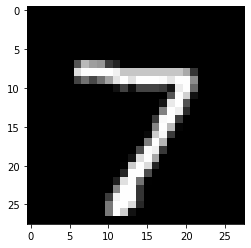

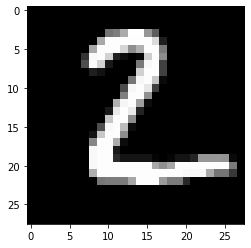

In [40]:
from matplotlib import pyplot as plt
first_image = np.array(image_1, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

second_image = np.array(image_2, dtype='float')
pixels = second_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

<a id="webservice_score"></a>
### Scoring of a webservice
If you want to make a `score` call on your deployment, please follow a below method:

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Deployment%20Jobs/deployment_jobs_create" 
target="_blank" rel="noopener no referrer">Create deployment job</a>

#### The deployment takes an hand written image_1 (digit 7) and image_2 (digit 2) as an input and returns class probabilities ( in exponential value) that were predicted (from digit 0 to 9).



In [38]:
%%bash -s "$image_1" "$image_2"

curl -sk -X POST \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data '{"space_id": "$SPACE_ID","input_data": [{"values": ['"$1"', '"$2"']}]}' \
    "$DATAPLATFORM_URL/ml/v4/deployments/$DEPLOYMENT_ID/predictions?version=2020-08-01" \
    | python -m json.tool

{
    "predictions": [
        {
            "values": [
                [
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    1.0,
                    0.0,
                    0.0
                ],
                [
                    0.0,
                    0.0,
                    1.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0
                ]
            ]
        }
    ]
}


<a id="deployments_list"></a>
### Listing all deployments

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Deployments/deployments_list" 
target="_blank" rel="noopener no referrer">List deployments details</a>

In [ ]:
%%bash

curl -sk -X GET \
    --header "Authorization: Bearer $TOKEN" \
    --header "Content-Type: application/json" \
    "$DATAPLATFORM_URL/ml/v4/deployments?space_id=$SPACE_ID&version=2020-08-01" \
    | python -m json.tool

<a id="cleaning"></a>
## 6. Cleaning section

Below section is useful when you want to clean all of your previous work within this notebook.
Just convert below cells into the `code` and run them.

<a id="training_delete"></a>
### Delete training run
**Tip:** You can completely delete a training run with its metadata.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Trainings/trainings_delete" 
target="_blank" rel="noopener no referrer">Deleting training</a>

<a id="deployment_delete"></a>
### Deleting deployment
**Tip:** You can delete existing deployment by calling DELETE method.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Deployments/deployments_delete" 
target="_blank" rel="noopener no referrer">Delete deployment</a>

<a id="model_delete"></a>
### Delete model from repository
**Tip:** If you want to completely remove your stored model and model metadata, just use a DELETE method.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Models/models_delete" 
target="_blank" rel="noopener no referrer">Delete model from repository</a>

<a id="def_delete"></a>
### Delete model definition
**Tip:** If you want to completely remove your model definition, just use a DELETE method.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Model%20Definitions/model_definitions_delete" 
target="_blank" rel="noopener no referrer">Delete model definition</a>

<a id="summary"></a>
## 7. Summary and next steps

 You successfully completed this notebook!.
 
 You learned how to use `cURL` calls to store, deploy and score a PyTorch Deep Learning model in Watson Machine Learning. 

### Authors

**Jan Sołtysik**, Intern in Watson Machine Learning at IBM

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.